**Dataset exploration and investigation for the Event Disruption Use Case**

This notebook contains an incomplete attempt to import event/planned works data from Melbourne City's open datasets, and to overlay it with their pedestrian sensor data.

The idea is to see if the sensor is inside, adjacent to, or close to the event, and then to measure the impacts of this proximity. The event dataset's geo information is contained in shape files, while the sensors are point coordinates. I have added buffers to the shapes to expand them slightly, so that we can see if the sensor point coordinates fit in either the shape itself, or slightly expanded versions (i.e. 'inside', 'adjacent' or 'near')

Currently it provides a quick visualisation of the concept, then creates the first merged dataset that will be required for deeper analysis.

Some graphs are created which show how pedestrian traffic over the course of an average day is effected by the proximity of events.

In [1]:
#Import a bunch of stuff that we need for this task

from shapely.geometry import Point, Polygon, shape, MultiPolygon

from sodapy import Socrata
import pandas as pd
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML

import geopandas as gpd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
#This is a quick way to import the geospatial 'event' data from the CoM repository

activities_url="https://data.melbourne.vic.gov.au/api/geospatial/txcy-uafv?method=export&format=GeoJSON"
activities_gdf=gpd.read_file(activities_url)

In [3]:
#Some pre-processing of that event dataset to help us later on

activities_gdf.start_date = pd.to_datetime(activities_gdf.start_date, format='%Y-%m-%d')
activities_gdf.end_date = pd.to_datetime(activities_gdf.end_date, format='%Y-%m-%d')
activities_gdf['start_year'] = activities_gdf.start_date.dt.year
activities_gdf['start_month'] = activities_gdf.start_date.dt.month_name()
activities_gdf['start_mdate'] = activities_gdf.start_date.dt.day
activities_gdf['start_time'] = activities_gdf.start_date.dt.hour
activities_gdf['end_year'] = activities_gdf.end_date.dt.year
activities_gdf['end_month'] = activities_gdf.end_date.dt.month_name()
activities_gdf['end_mdate'] = activities_gdf.end_date.dt.day
activities_gdf['end_time'] = activities_gdf.end_date.dt.hour

activities_gdf = activities_gdf.drop(['location', 'source_id', 'small_area','notes', 'status'], axis=1)

activities_gdf['adjacent'] = activities_gdf['geometry'].buffer(0.0005)
activities_gdf['near'] = activities_gdf['geometry'].buffer(0.001)

In [4]:
#Have a look at the different types of event or activity
activities_gdf.classification.unique()

array(['Structures', 'Reserved Parking', 'Event', 'Public Event',
       'Traffic Management', 'Private Event', 'Sport/Recreation'],
      dtype=object)

In [5]:
#From looking at the different types of event, it seems as though some could increase
#pedestrian activity, and some could decrease it
#A sporting event might bring people in whereas traffic management might make people
#avoid an area


In [6]:
#for a quick example, we might just want to look at events that are still current
#note that this is hardcoded, and would soon be inaccurate

current_act = activities_gdf[((activities_gdf.end_year == 2022) 
                              & (activities_gdf.end_month.isin(['September', 'October', 'August', 'December', 'November'])))
                            | (activities_gdf.end_year > 2022)]

In [7]:
#Now we grab the sensor location data

def sensor_location():
    client = Socrata('data.melbourne.vic.gov.au', 'nlPM0PQJSjzCsbVqntjPvjB1f', None)
    sensor_location_data_id = "h57g-5234"
    results = client.get(sensor_location_data_id)
    df = pd.DataFrame.from_records(results)
    sensor_location = df[["sensor_id", "latitude", "longitude", "sensor_description"]]
    sensor_location.columns = ["sensor_id", "lat", "lon", "sensor_description"]
    sensor_location["lat"] = sensor_location["lat"].apply(lambda x: float(x))
    sensor_location["lon"] = sensor_location["lon"].apply(lambda x: float(x))
    return sensor_location

location_data = sensor_location()

location_data['sensor_id'] = location_data['sensor_id'].astype(int)


In [8]:
#This map just demonstrates the 'geometry', 'adjacent' and 'near' polygons.
#This is so we can compare whether a sensor is inside an event's geometry, adjacent to it, or near to it.

style1 = {'fillColor': 'red', 'color': 'red'}
style2 = {'fillColor': 'orange', 'color': 'orange'}
style3 = {'fillColor': 'yellow', 'color': 'yellow'}

import folium

#Create a map object centered on Melbourne
map = folium.Map(location=[-37.81216592937499, 
                           144.961812290625], 
                          zoom_start=14)

#Add the current events to the map
folium.GeoJson(data=current_act.geometry, style_function=lambda x:style1).add_to(map)
folium.GeoJson(data=current_act.adjacent, style_function=lambda x:style2).add_to(map)
folium.GeoJson(data=current_act.near, style_function=lambda x:style3).add_to(map)

#Add all sensor locations
for i in range(0,len(location_data)):
   folium.Marker(
      location=[location_data.iloc[i]['lat'], location_data.iloc[i]['lon']],
      popup=location_data.iloc[i]['sensor_description']
   ).add_to(map)

map

In [9]:
#The previous visualisation showed two different datasets on the same map. That's fine for visualisation,
#but not really sufficient for deeper analysis.
#The next steps will require a combined dataset.
#This new dataset will combine the sensor ids and the event geography.

activities_gdf[["In","Adjacent","Near"]] = None
activities_gdf[["In","Adjacent","Near"]] = activities_gdf[["In","Adjacent","Near"]].astype('object')

for i in range(activities_gdf.shape[0]):
    for j in range(location_data.shape[0]):
        if MultiPolygon(activities_gdf.geometry[i]).contains(Point(location_data.lon[j], location_data.lat[j])):
            try:
                activities_gdf.In[i] += ', ' 
                activities_gdf.In[i] += str(location_data.sensor_description[j])
            except:
                activities_gdf.In[i] = str(location_data.sensor_description[j])

        elif Polygon(activities_gdf.adjacent[i]).contains(Point(location_data.lon[j], location_data.lat[j])):
            try:
                activities_gdf.Adjacent[i] += ', ' 
                activities_gdf.Adjacent[i] += str(location_data.sensor_description[j])
            except:
                activities_gdf.Adjacent[i] = str(location_data.sensor_description[j])

        elif Polygon(activities_gdf.near[i]).contains(Point(location_data.lon[j], location_data.lat[j])):
            try:
                activities_gdf.Near[i] += ', ' 
                activities_gdf.Near[i] += str(location_data.sensor_description[j])
            except:
                activities_gdf.Near[i] = str(location_data.sensor_description[j])
           

In [10]:
#Uncomment the below to open data source, download sensor data, and store it as a csv locally.

##Function to get Sensor count history data
# def sensor_count():
#     client = Socrata('data.melbourne.vic.gov.au', 'nlPM0PQJSjzCsbVqntjPvjB1f', None)
#     sensor_data_id = "b2ak-trbp"
#     results = client.get(sensor_data_id, limit=5000000)
#     df = pd.DataFrame.from_records(results)
#     df = df[['date_time', 'year', 'month', 'mdate', 'day', 'time', 'sensor_id', 'sensor_name', 'hourly_counts']]
#     return df

# sensor_history = sensor_count()

# sensor_history.to_csv('sensor_history.csv', index=False)

In [11]:
sensor_history = pd.read_csv('sensor_history.csv')

In [12]:
sensor_location = location_data.copy()
# sensor_location['sensor_id'] = sensor_location['Sensor ID'].astype(int)
# sensor_location = sensor_location.drop(['Sensor ID', 'Sensor Description'], axis=1)
sensor_history = sensor_history.merge(sensor_location, on=('sensor_id'), how='inner')

In [13]:
#Now we are going to investgate a sample.
#For this we are going to look at a busy central sensor, 'Town Hall (West)'
#And we will grab the pedestrian count for every hour for the whole of 2021.

sample_THW = sensor_history.loc[(sensor_history.sensor_name == 'Town Hall (West)')
                  & (sensor_history.year == 2021)]

In [14]:
#Convert the datetime back into a datetime format
sample_THW.date_time = pd.to_datetime(sample_THW.date_time)

In [15]:
sample_THW.head()

,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,lat,lon,sensor_description
1303336,2021-01-01 00:00:00,2021,January,1,Friday,0,4,Town Hall (West),1461,-37.814867,144.966094,Town Hall (West)
1303337,2021-01-01 01:00:00,2021,January,1,Friday,1,4,Town Hall (West),860,-37.814867,144.966094,Town Hall (West)
1303338,2021-01-01 02:00:00,2021,January,1,Friday,2,4,Town Hall (West),597,-37.814867,144.966094,Town Hall (West)
1303339,2021-01-01 03:00:00,2021,January,1,Friday,3,4,Town Hall (West),393,-37.814867,144.966094,Town Hall (West)
1303340,2021-01-01 04:00:00,2021,January,1,Friday,4,4,Town Hall (West),242,-37.814867,144.966094,Town Hall (West)


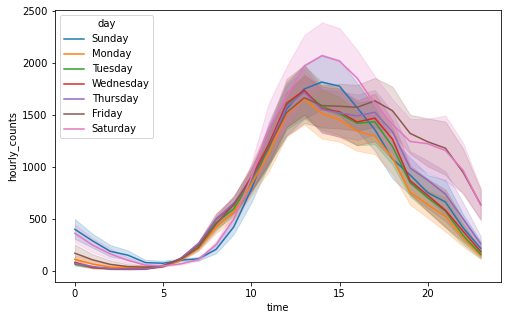

In [16]:
#Plot a years's worth of hourly counts in the warmer months
hue_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

plt.figure(figsize=(8,5))
sns.lineplot(x='time', y='hourly_counts', hue='day', hue_order = hue_order,
             data = sample_THW[sample_THW.month.isin(['September', 'October', 'November', 'December', 'January'
                                                    , 'February', 'March', 'April'])])
plt.show()

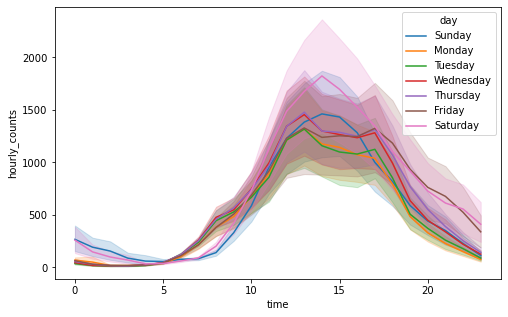

In [17]:
#Plot a years's worth of hourly counts in the other months

plt.figure(figsize=(8,5))
sns.lineplot(x='time', y='hourly_counts', hue = 'day', hue_order = hue_order,
             data = sample_THW[~sample_THW.month.isin(['September', 'October', 'November', 'December', 'January'
                                                    , 'February', 'March', 'April'])])
plt.show()

In [18]:
# test = sensor_history[sensor_history.date_time > "2020-01-01"][0:100000]
combined = sensor_history.copy()
combined[["In","Adjacent","Near"]] = 0
combined.date_time = pd.to_datetime(combined.date_time)

In [19]:
for i in range (0, len(location_data)):
    for j in range (0, len(activities_gdf)):
        try:
            if location_data.sensor_description.iloc[i] in activities_gdf.Near.iloc[j]:
                combined.loc[(combined.date_time > activities_gdf.start_date.iloc[j])
                & (combined.date_time < activities_gdf.end_date.iloc[j])
                & (combined.sensor_id == location_data.sensor_id.iloc[i]), 'Near'] += 1
        except:
            pass
        try:
            if location_data.sensor_description.iloc[i] in activities_gdf.In.iloc[j]:
                combined.loc[(combined.date_time > activities_gdf.start_date.iloc[j])
                & (combined.date_time < activities_gdf.end_date.iloc[j])
                & (combined.sensor_id == location_data.sensor_id.iloc[i]), 'In'] += 1
        except:
            pass
        try:
            if location_data.sensor_description.iloc[i] in activities_gdf.Adjacent.iloc[j]:
                combined.loc[(combined.date_time > activities_gdf.start_date.iloc[j])
                & (combined.date_time < activities_gdf.end_date.iloc[j])
                & (combined.sensor_id == location_data.sensor_id.iloc[i]), 'Adjacent'] += 1
        except:
            pass

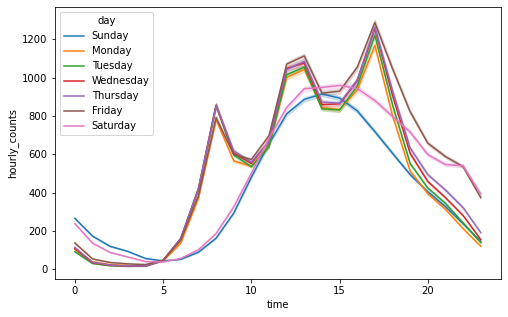

In [20]:
plt.figure(figsize=(8,5))
sns.lineplot(x='time', y='hourly_counts', hue = 'day', hue_order = hue_order,
             data = combined)
plt.show()

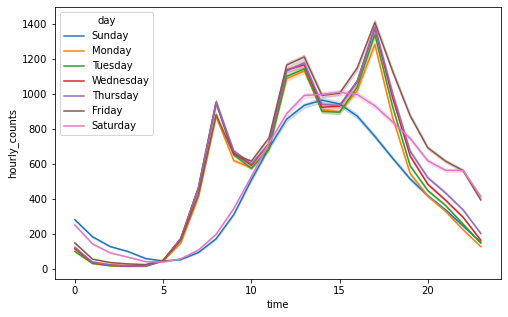

In [21]:
plt.figure(figsize=(8,5))
sns.lineplot(x='time', y='hourly_counts', hue = 'day', hue_order = hue_order,
             data = combined[(combined.In == 0)
                        & (combined.Adjacent == 0)
                        & (combined.Near == 0)])
plt.show()

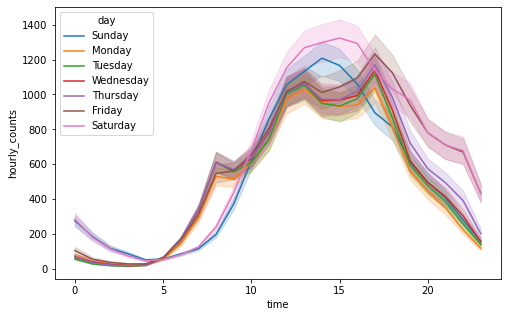

In [22]:
plt.figure(figsize=(8,5))
sns.lineplot(x='time', y='hourly_counts', hue = 'day', hue_order = hue_order,
             data = combined[combined.In != 0])
plt.show()

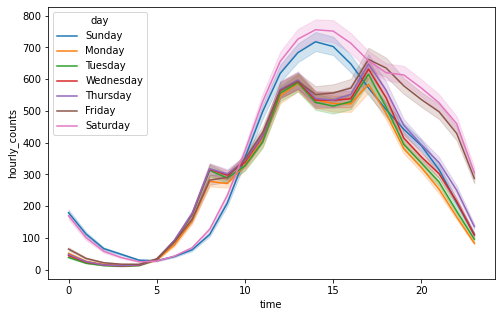

In [23]:
plt.figure(figsize=(8,5))
sns.lineplot(x='time', y='hourly_counts', hue = 'day', hue_order = hue_order,
             data = combined[combined.Adjacent != 0])
plt.show()

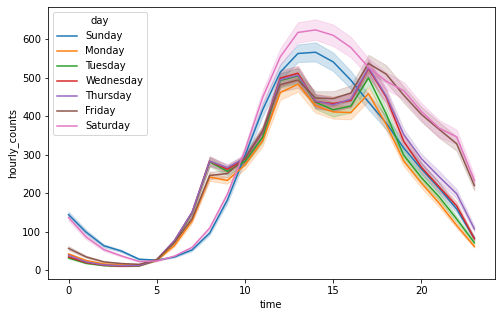

In [24]:
plt.figure(figsize=(8,5))
sns.lineplot(x='time', y='hourly_counts', hue = 'day', hue_order = hue_order,
             data = combined[combined.Near != 0])
plt.show()

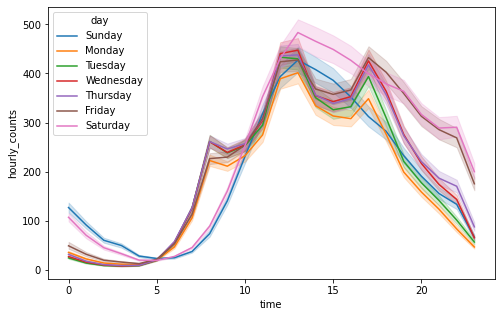

In [25]:
plt.figure(figsize=(8,5))
sns.lineplot(x='time', y='hourly_counts', hue = 'day', hue_order = hue_order,
             data = combined[(combined.Near != 0)
                        & (combined.In == 0)
                        & (combined.Adjacent == 0)])
plt.show()

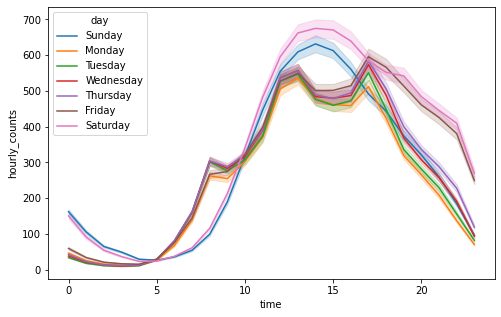

In [26]:
plt.figure(figsize=(8,5))
sns.lineplot(x='time', y='hourly_counts', hue = 'day', hue_order = hue_order,
             data = combined[(combined.Near != 0)
                        | (combined.In != 0)
                        | (combined.Adjacent != 0)])
plt.show()

In [27]:
combined = sensor_history.copy()
combined[["Traffic_In","Traffic_Adjacent","Traffic_Near", "Pub_Ev_In", "Pub_Ev_Adjacent", "Pub_Ev_Near"]] = 0
combined.date_time = pd.to_datetime(combined.date_time)

In [28]:
for i in range (0, len(location_data)):
    for j in range (0, len(activities_gdf)):
        try:
            if location_data.sensor_description.iloc[i] in activities_gdf.Near.iloc[j]:
                combined.loc[(combined.date_time > activities_gdf.start_date.iloc[j])
                & (combined.date_time < activities_gdf.end_date.iloc[j])
                & (combined.sensor_id == location_data.sensor_id.iloc[i])
                & (activities_gdf.classification.iloc[j] == "Traffic Management"), 'Traffic_Near'] += 1
        except:
            pass
        try:
            if location_data.sensor_description.iloc[i] in activities_gdf.In.iloc[j]:
                combined.loc[(combined.date_time > activities_gdf.start_date.iloc[j])
                & (combined.date_time < activities_gdf.end_date.iloc[j])
                & (combined.sensor_id == location_data.sensor_id.iloc[i])
                & (activities_gdf.classification.iloc[j] == "Traffic Management"), 'Traffic_In'] += 1
        except:
            pass
        try:
            if location_data.sensor_description.iloc[i] in activities_gdf.Adjacent.iloc[j]:
                combined.loc[(combined.date_time > activities_gdf.start_date.iloc[j])
                & (combined.date_time < activities_gdf.end_date.iloc[j])
                & (combined.sensor_id == location_data.sensor_id.iloc[i])
                & (activities_gdf.classification.iloc[j] == "Traffic Management"), 'Traffic_Adjacent'] += 1
        except:
            pass
        try:
            if location_data.sensor_description.iloc[i] in activities_gdf.Near.iloc[j]:
                combined.loc[(combined.date_time > activities_gdf.start_date.iloc[j])
                & (combined.date_time < activities_gdf.end_date.iloc[j])
                & (combined.sensor_id == location_data.sensor_id.iloc[i])
                & (activities_gdf.classification.iloc[j] == "Public Event"), 'Pub_Ev_Near'] += 1
        except:
            pass
        try:
            if location_data.sensor_description.iloc[i] in activities_gdf.In.iloc[j]:
                combined.loc[(combined.date_time > activities_gdf.start_date.iloc[j])
                & (combined.date_time < activities_gdf.end_date.iloc[j])
                & (combined.sensor_id == location_data.sensor_id.iloc[i])
                & (activities_gdf.classification.iloc[j] == "Public Event"), 'Pub_Ev_In'] += 1
        except:
            pass
        try:
            if location_data.sensor_description.iloc[i] in activities_gdf.Adjacent.iloc[j]:
                combined.loc[(combined.date_time > activities_gdf.start_date.iloc[j])
                & (combined.date_time < activities_gdf.end_date.iloc[j])
                & (combined.sensor_id == location_data.sensor_id.iloc[i])
                & (activities_gdf.classification.iloc[j] == "Public Event"), 'Pub_Ev_Adjacent'] += 1
        except:
            pass

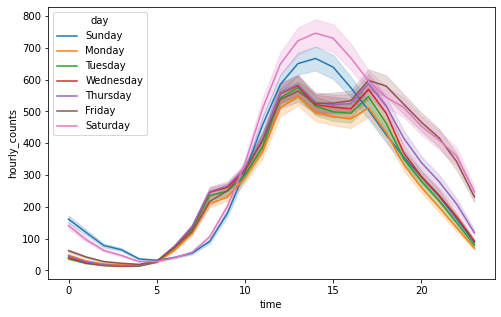

In [29]:
plt.figure(figsize=(8,5))
sns.lineplot(x='time', y='hourly_counts', hue = 'day', hue_order = hue_order,
             data = combined[(combined.Traffic_Near != 0)
                        | (combined.Traffic_In != 0)
                        | (combined.Traffic_Adjacent != 0)])
plt.show()

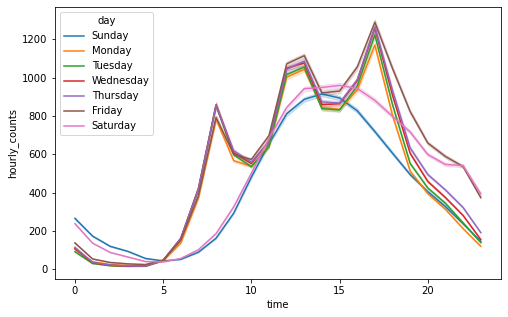

In [30]:
plt.figure(figsize=(8,5))
sns.lineplot(x='time', y='hourly_counts', hue = 'day', hue_order = hue_order,
             data = combined[(combined.Traffic_Near == 0)
                        | (combined.Traffic_In == 0)
                        | (combined.Traffic_Adjacent == 0)])
plt.show()

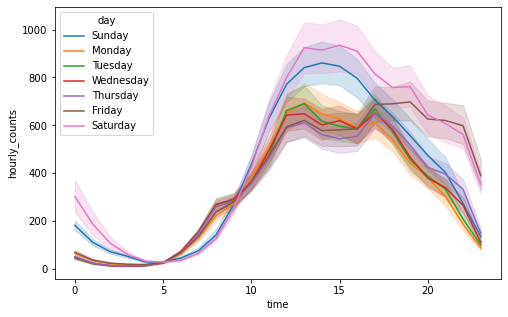

In [31]:
plt.figure(figsize=(8,5))
sns.lineplot(x='time', y='hourly_counts', hue = 'day', hue_order = hue_order,
             data = combined[(combined.Pub_Ev_Near != 0)
                        | (combined.Pub_Ev_In != 0)
                        | (combined.Pub_Ev_Adjacent != 0)])
plt.show()

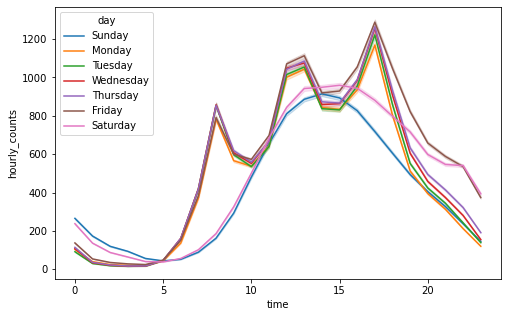

In [32]:
plt.figure(figsize=(8,5))
sns.lineplot(x='time', y='hourly_counts', hue = 'day', hue_order = hue_order,
             data = combined[(combined.Pub_Ev_Near == 0)
                        | (combined.Pub_Ev_In == 0)
                        | (combined.Pub_Ev_Adjacent == 0)])
plt.show()